In [1]:

# import zipfile

# # Specify the zip file path
# zip_file_path = 'Gun_NoGun_Dataset_augmented.zip'

# # Specify the extraction path
# extract_path = '.'

# # Open the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Extract all files
#     zip_ref.extractall(extract_path)

# print(f'Zip file extracted to {extract_path}')

In [2]:
import os
import cv2
import numpy as np
import random
import tensorflow as tf
from moviepy.editor import *
import matplotlib.pyplot as plt
import keras
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Input, RepeatVector, Dropout
from keras.models import Model
from keras.optimizers import Nadam, Adam
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout

2024-09-09 17:36:51.342696: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 17:36:51.417752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 17:36:51.440698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 17:36:51.447679: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 17:36:51.469586: I tensorflow/core/platform/cpu_feature_guar

In [3]:
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import *

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, Model

In [4]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:
data_dir =  "UCF_crime_subset/"
IMAGE_HEIGHT, IMAGE_WIDTH= 224,224

SEQUENCE_LENGTH =50

In [6]:
class_categories_list = ["Gun", "NoGun"]
model_output_length = len(class_categories_list)

In [7]:
max_pixel_value = 255
def extract_frame(video_path):
  # frames_list = []

  # #print(" the video file path is : {}".format(video_path))
  # videoObj = cv2.VideoCapture(video_path)
  # #print("the video object is: {}".format(videoObj))

  # """ Iterating through Video Frames """
  # while True:

  #   # Reading a frame from the video file
  #   success, image = videoObj.read()
  #   #print("the value of success is: {}".format(success))

  #   if not success:
  #     break

  #   resized_frame = cv2.resize(image, (image_height, image_width))

  #   """Normalize the resized frame by dividing it with 255 so that 
  #   each pixel value then lies between 0 and 1"""

  #   normalized_frame = resized_frame / max_pixel_value
  #   frames_list.append(normalized_frame)

    
  # videoObj.release()


    frames_list = []
    
    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)
    
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
    
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
    
        if not success:
            break
    
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    
    video_reader.release()


    return frames_list



In [8]:
def data_creation():

    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes.
    for class_index, class_name in enumerate(class_categories_list):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(data_dir, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(data_dir, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = extract_frame(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [9]:
features, labels = data_creation()

Extracting Data of Class: Gun
Extracting Data of Class: NoGun


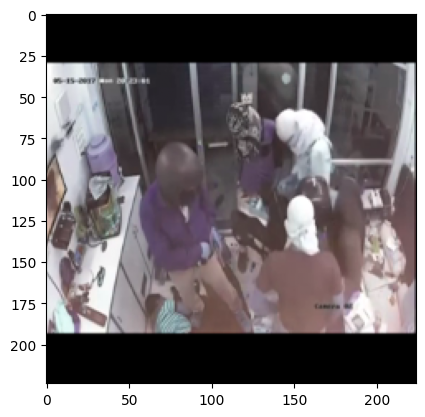

In [10]:
plt.imshow(features[1][40])

In [11]:
print("the shape of the feature = {}".format(features.shape))
print("the shape of the labels = {}".format(labels.shape))

the shape of the feature = (100, 50, 224, 224, 3)
the shape of the labels = (100,)


In [12]:
one_hot_encoded_labels = to_categorical(labels)

In [13]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, 
                                                                            test_size = 0.5, 
                                                                            shuffle = True, 
                                                                            random_state = 0)

In [14]:
print("the shape of the feature = {}".format(features_train.shape))
print("the shape of the labels = {}".format(labels_train.shape))

the shape of the feature = (50, 50, 224, 224, 3)
the shape of the labels = (50, 2)


In [15]:
print("the shape of the feature = {}".format(features_test.shape))
print("the shape of the labels = {}".format(labels_test.shape))

the shape of the feature = (50, 50, 224, 224, 3)
the shape of the labels = (50, 2)


In [16]:
from tensorflow.keras.models import load_model

no_of_channels = 3

# Load the saved model
VGG_model = load_model('VGG16_Date_Time_2024_08_17__16_23_00___Loss_0.13619327545166016___Accuracy_0.9503968358039856.h5')


# Define the input shape
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, no_of_channels)

# Remove the classification head (last layer)
VGG_model = Model(inputs=VGG_model.inputs, outputs=VGG_model.layers[-5].output)

# Set the new input shape
VGG_model.build(input_shape)

# Print the updated model summary
VGG_model.summary()

2024-09-09 17:38:44.036575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 23926 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:1a:00.0, compute capability: 8.0
2024-09-09 17:38:44.038322: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 35626 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:1b:00.0, compute capability: 8.0
2024-09-09 17:38:44.040939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 35602 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3d:00.0, compute capability: 8.0
2024-09-09 17:38:44.044023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 33451 MB memory:  -> device: 3, name: NVIDIA A100-PCIE-40GB, pci bu

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
video_input = Input(shape=(SEQUENCE_LENGTH,
                           IMAGE_HEIGHT,
                            IMAGE_WIDTH,
                            no_of_channels))

In [18]:
video_frames_encoded = TimeDistributed(VGG_model)(video_input)

In [19]:
video_frames_encoded

<KerasTensor shape=(None, 50, 512), dtype=float32, sparse=False, name=keras_tensor_49>

In [20]:
no_of_classes = 2

In [21]:
video_frames_encoded_sequence = LSTM(256)(video_frames_encoded)
#video_frames_encoded_sequence = Dropout(0.5)(video_frames_encoded_sequence)

hidden_layer1 = Dense(1024, activation="relu")(video_frames_encoded_sequence)
#hidden_layer1 = Dropout(0.5)(hidden_layer1)

hidden_layer2 = Dense(512, activation="relu")(hidden_layer1)
#hidden_layer2 = Dropout(0.5)(hidden_layer2)

hidden_layer3 = Dense(256, activation="relu")(hidden_layer2)
#hidden_layer3 = Dropout(0.25)(hidden_layer3)

hidden_layer4 =  Dense(128, activation="relu")(hidden_layer3)
#hidden_layer4 = Dropout(0.25)(hidden_layer4)

hidden_layer5 =  Dense(64, activation="relu")(hidden_layer4)
#hidden_layer5 = Dropout(0.25)(hidden_layer5)

outputs = Dense(no_of_classes, activation="softmax")(hidden_layer5)
model = Model([video_input], outputs)

In [22]:
optimizer = Adam(learning_rate=0.000005)
                  # beta_1=0.9,
                  # beta_2=0.999,
                  # epsilon=1e-08,
                  # weight_decay=0.004)

In [23]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"]) 

In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 512)        │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,462,722 (62.80 MB)

 Trainable params: 1,748,034 (6.67 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor="val_loss",
                      mode="min",
                      restore_best_weights=True,
                      patience=5)
checkpoint = ModelCheckpoint('VGG+LSTM_best_weights(UCF_Crime(50-50)).keras',
                             monitor='val_accuracy',
                            #  monitor='val_f1_score',
                             verbose=1,
                             mode='max',
                             save_best_only=True)
callbacks = [early_stopping_callback, checkpoint]

In [26]:
features_train.shape, labels_train.shape

((50, 50, 224, 224, 3), (50, 2))

In [27]:
# Start Training
model_training_history = model.fit(x = features_train, 
                                   y = labels_train, 
                                   epochs = 150, 
                                   batch_size = 8,
                                   shuffle = True, 
                                   callbacks=[callbacks],
                                   validation_split = 0.2)

Epoch 1/150


2024-09-09 17:39:07.250579: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1725917947.362006  195694 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917947.390126  195694 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917947.424247  195694 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917947.425489  195694 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917947.426797  195694 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917947.428129  195694 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917947.432096  195694 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917947.433478  195694 gpu_t

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.5033 - loss: 0.6911

W0000 00:00:1725917958.347603  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.348837  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.349999  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.351169  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.352326  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.353504  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.354710  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.355873  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.357068  195692 gp


Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to VGG+LSTM_best_weights(UCF_Crime(50-50)).keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.4986 - loss: 0.6912 - val_accuracy: 0.6000 - val_loss: 0.6850
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.5625 - loss: 0.6889
Epoch 2: val_accuracy improved from 0.60000 to 0.70000, saving model to VGG+LSTM_best_weights(UCF_Crime(50-50)).keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 967ms/step - accuracy: 0.5521 - loss: 0.6890 - val_accuracy: 0.7000 - val_loss: 0.6847
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.6263 - loss: 0.6878
Epoch 3: val_accuracy improved from 0.70000 to 0.80000, saving model to VGG+LSTM_best_weights(UCF_Crime(50-50)).keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 856ms/step - accuracy: 0.6219 - loss: 0.6880 - val_accuracy: 0.8000 - val_loss: 0.6844
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.6571 - loss: 0.6869
Epoch 4: val_accuracy did not improve from 0.80000

In [28]:
features_test.shape

(50, 50, 224, 224, 3)

In [29]:
# import datetime as dt

# model2_evaluation_history = model.evaluate(features_test, labels_test)

# date_time_format = '%Y_%m_%d__%H_%M_%S'
# current_date_time_dt = dt.datetime.now()

# current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
# model_evaluation_loss, model_evaluation_accuracy = model2_evaluation_history
# model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
# # Saving your Model
# model.save(model_name)


In [30]:
labels_pred = model.predict(features_test)

W0000 00:00:1725918464.461596  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918464.473518  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918464.480726  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918464.488281  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918464.496061  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918464.504774  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918464.510999  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918464.518546  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918464.528092  195692 gp

1/2 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step

W0000 00:00:1725918466.591187  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918466.592778  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918466.594377  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918466.595976  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918466.597611  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918466.599265  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918466.600904  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918466.602564  195692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918466.604232  195692 gp

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 9s/step


In [31]:
labels_pred = np.argmax(labels_pred, axis = 1)
labels_test = np.argmax(labels_test, axis = 1)
labels_pred, labels_test

(array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0]),
 array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0]))

In [32]:
from sklearn.metrics import classification_report
report = classification_report(labels_test, labels_pred)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.71      0.77      0.74        26
           1       0.73      0.67      0.70        24

    accuracy                           0.72        50
   macro avg       0.72      0.72      0.72        50
weighted avg       0.72      0.72      0.72        50



In [ ]:
labels_pred_prob = model.predict(features_test)

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_metric(measure_name_1, measure_name_2, plot_title):
  
 
  measure_value_1 = model_training_history.history[measure_name_1]
  measure_value_2 = model_training_history.history[measure_name_2] 
  epochs = range(len(measure_value_1))

  plt.plot(epochs, measure_value_1, 'blue', label = measure_name_1)
  plt.plot(epochs, measure_value_2, 'red', label = measure_name_2)   

  plt.title(str(plot_title))
  plt.legend()
  plt.show()


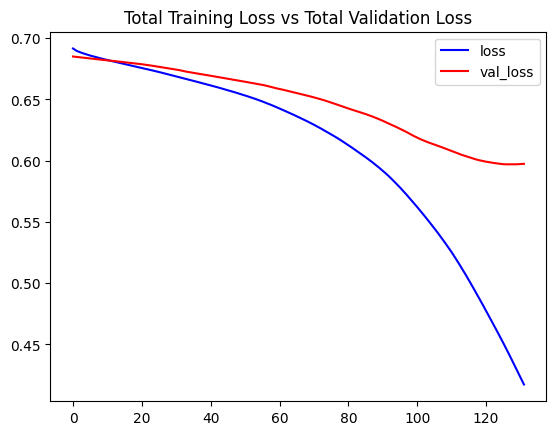

In [34]:
plot_metric('loss', 'val_loss', 'Total Training Loss vs Total Validation Loss')

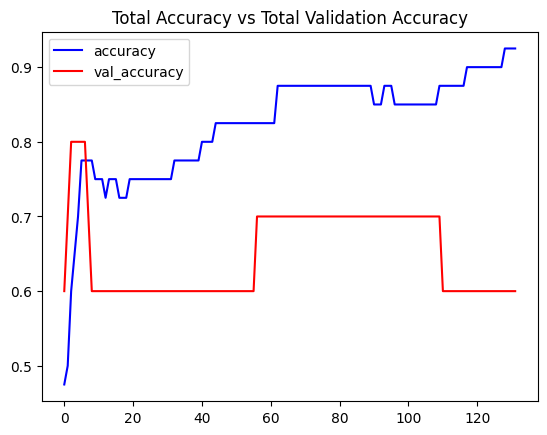

In [35]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [36]:
labels_pred_prob = model.predict(features_test)
labels_pred_prob

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 978ms/step


array([[0.53718454, 0.46281543],
       [0.5980082 , 0.40199178],
       [0.5025307 , 0.49746928],
       [0.42251635, 0.57748365],
       [0.69326437, 0.3067357 ],
       [0.49739233, 0.50260764],
       [0.7161338 , 0.28386617],
       [0.39019033, 0.6098097 ],
       [0.27959642, 0.72040355],
       [0.508542  , 0.49145797],
       [0.7352535 , 0.2647465 ],
       [0.26141763, 0.7385824 ],
       [0.32706773, 0.67293227],
       [0.28152415, 0.7184759 ],
       [0.5825705 , 0.4174295 ],
       [0.51303226, 0.4869677 ],
       [0.7239328 , 0.27606723],
       [0.54503924, 0.45496082],
       [0.6817354 , 0.31826466],
       [0.4585278 , 0.54147226],
       [0.31651217, 0.68348783],
       [0.54381573, 0.4561843 ],
       [0.7387812 , 0.2612188 ],
       [0.39996254, 0.60003746],
       [0.5585671 , 0.44143286],
       [0.60454524, 0.39545473],
       [0.7204155 , 0.2795845 ],
       [0.3367557 , 0.6632443 ],
       [0.64748085, 0.35251912],
       [0.32469174, 0.6753082 ],
       [0.

In [44]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr, tpr, thresholds = roc_curve(labels_test, labels_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
auc_score = roc_auc_score(labels_test, labels_pred_prob[:, 1])
print(auc_score)


0.7564102564102564


In [41]:
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , 0.07692308, 0.07692308,
        0.11538462, 0.11538462, 0.15384615, 0.15384615, 0.19230769,
        0.19230769, 0.23076923, 0.23076923, 0.26923077, 0.26923077,
        0.30769231, 0.30769231, 0.34615385, 0.34615385, 0.5       ,
        0.5       , 0.57692308, 0.57692308, 0.73076923, 0.73076923,
        0.92307692, 0.92307692, 1.        ]),
 array([0.        , 0.04166667, 0.125     , 0.125     , 0.41666667,
        0.41666667, 0.45833333, 0.45833333, 0.5       , 0.5       ,
        0.54166667, 0.54166667, 0.66666667, 0.66666667, 0.70833333,
        0.70833333, 0.75      , 0.75      , 0.79166667, 0.79166667,
        0.875     , 0.875     , 0.91666667, 0.91666667, 0.95833333,
        0.95833333, 1.        , 1.        ]),
 array([       inf, 0.7385824 , 0.72040355, 0.68348783, 0.6098097 ,
        0.6096568 , 0.60003746, 0.5798017 , 0.57748365, 0.57273793,
        0.5675234 , 0.54147226, 0.50260764, 0.49746928, 0.49145797,
        0.4869677 , 0.47

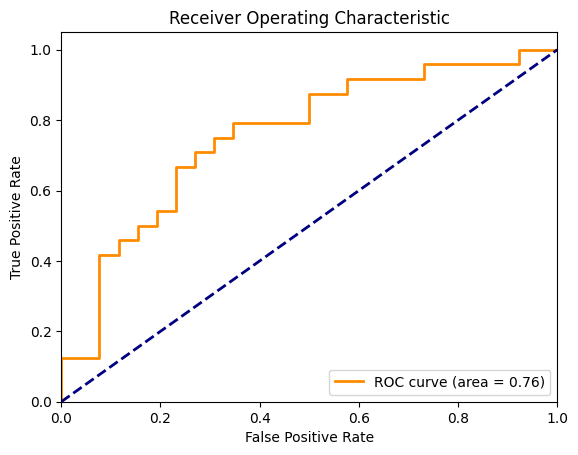

In [42]:
# Plot ROC curve
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()